## NN datos balanceados undersampling



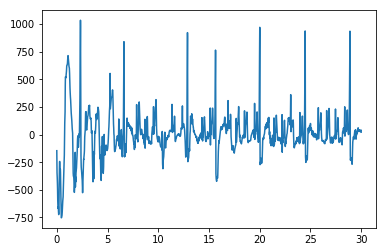

In [12]:
#load data
#load data
%matplotlib inline
import matplotlib.pyplot as plt
#load data
import numpy as np

X_train = np.load('X_train.npy')
y_train = np.load('y_train.npy')

X_test = np.load('X_test.npy')
y_test = np.load('y_test.npy')

#Decimamos

X_train = np.load('X_train.npy')
y_train = np.load('y_train.npy')

X_test = np.load('X_test.npy')
y_test = np.load('y_test.npy')

fs = 300. #hz
t = np.arange(len(X_train[0]))/fs
plt.plot(t,X_train[0,:])

#Es probable que tengamos un problema mal condicionado: vamos a realizar un submuestreo de la señal a 50 muestras por segundo
from scipy import signal

decimate = False

if decimate:
    freq = fs/10#Hz
    print(freq)
    secs = len(X_train[200])/fs
    samps = int(secs*freq)
    c = 0
    X_new = np.zeros((X_train.shape[0],samps))
    X_new_test = np.zeros((X_test.shape[0],samps))
    for x,x_test in zip(X_train,X_test):
        X_new[c,:] = signal.decimate(x,10,ftype = 'fir')
        X_new_test[c,:] = signal.decimate(x_test,10,ftype = 'fir')
    
        c += 1
    
    t = np.arange(len(X_new[200]))/freq
    plt.plot(t,X_new[200,:])
    print(len(X_new[0]))

    X_train = X_new.copy()
    X_test = X_new_test.copy()

In [13]:
from sklearn.preprocessing import StandardScaler

#normalizamos train
my_scaler = StandardScaler()

X_train_n = my_scaler.fit_transform(X_train)

/home/miguelangel/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [14]:
#Vamos a probar balanceando con under sampling y over sampling
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=0, replacement=True)
X_resampled, y_resampled = rus.fit_sample(X_train_n, y_train)

from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=0)
X_oversampled, y_oversampled = ros.fit_sample(X_train_n, y_train)

print('"""""""""""""""""""""""""""""""""""""""""""""""""')
print('"""""""""""""""""""""""""""""""""""""""""""""""""')
print("y_resampled")
print(sorted(Counter(y_resampled).items()))

print("y_oversampled")
print(sorted(Counter(y_oversampled).items()))


print("y_train")
print(sorted(Counter(y_train).items()))

"""""""""""""""""""""""""""""""""""""""""""""""""
"""""""""""""""""""""""""""""""""""""""""""""""""
y_resampled
[(0, 100), (1, 100), (2, 100), (3, 100)]
y_oversampled
[(0, 2942), (1, 2942), (2, 2942), (3, 2942)]
y_train
[(0, 2942), (1, 399), (2, 1340), (3, 100)]


In [15]:
#función para crear un modelo de un número determinado de capas

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from keras import initializers
from keras.layers.normalization import BatchNormalization
import keras


#f1 score
from keras import backend as K

def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def create_model(N,n_hidd = [2,2,2],p = 0):
    """
    Modelo de red neuronal. 
    
    N: number of input featurs
    n_hidd indica la arquitectura del modelo: n_cols = número de capas, value for eahc col, the number of hidden
    units
    """
    
    model = Sequential()
    
    #input layer
    model.add(Dense(n_hidd[0],input_dim = N,activation = 'relu'))
    model.add(BatchNormalization())
    
    #hidden layers
    for n_h in n_hidd[1:]:
        model.add(Dense(n_h,activation='relu',kernel_initializer=initializers.he_normal(seed=None)))
        model.add(BatchNormalization())  
        model.add(Dropout(p))
        
    #output layer
    model.add(Dense(4,activation = 'softmax'))
   

    opt =keras.optimizers.Adam(lr = 4e-3)
    #compile model
    model.compile(loss='categorical_crossentropy',optimizer = opt,metrics = ['accuracy',f1])
    return model

In [16]:
## dev and train split

#Split data into dev and trin
from sklearn.model_selection import StratifiedShuffleSplit
skf = StratifiedShuffleSplit(n_splits = 1,test_size = 0.20)

#WARNING que volvemos a llamar train
for train, dev in skf.split(X_resampled,y_resampled):
    X_train, X_dev = X_resampled[train], X_resampled[dev]
    y_train, y_dev = y_resampled[train], y_resampled[dev]
    
print(X_train.shape)
print(X_dev.shape)

(320, 9000)
(80, 9000)


In [17]:
#Entrenamos el modelo 

N = X_train.shape[1]#number of features
n_h = [int(N/2),int(N/4),int(N/8),int(N/16),int(N/32)]
print(n_h)
print(N)
prob_dropout = 0.5
model = KerasClassifier(build_fn = create_model,N=N,n_hidd=n_h,p = prob_dropout,epochs = 200, batch_size = 10, verbose = 1)

history = model.fit(X_train,y_train)

[4500, 2250, 1125, 562, 281]
9000
Epoch 1/200
320/320 [==============================] - 40s 125ms/step - loss: 2.4328 - acc: 0.3188 - f1: 0.2851
Epoch 2/200
320/320 [==============================] - 38s 120ms/step - loss: 2.0704 - acc: 0.3094 - f1: 0.2841
Epoch 3/200
320/320 [==============================] - 38s 120ms/step - loss: 1.6791 - acc: 0.3563 - f1: 0.3136
Epoch 4/200
320/320 [==============================] - 40s 123ms/step - loss: 1.7081 - acc: 0.3469 - f1: 0.2792
Epoch 5/200
320/320 [==============================] - 43s 135ms/step - loss: 1.4333 - acc: 0.4406 - f1: 0.3985
Epoch 6/200
320/320 [==============================] - 42s 131ms/step - loss: 1.3320 - acc: 0.4594 - f1: 0.4028
Epoch 7/200
320/320 [==============================] - 40s 126ms/step - loss: 1.3067 - acc: 0.4813 - f1: 0.3979
Epoch 8/200
320/320 [==============================] - 42s 131ms/step - loss: 1.1742 - acc: 0.5406 - f1: 0.4946
Epoch 9/200
320/320 [==============================] - 39s 121ms/step 

320/320 [==============================] - 38s 120ms/step - loss: 0.2573 - acc: 0.9312 - f1: 0.9308
Epoch 74/200
320/320 [==============================] - 39s 120ms/step - loss: 0.1698 - acc: 0.9437 - f1: 0.9437
Epoch 75/200
320/320 [==============================] - 39s 122ms/step - loss: 0.2168 - acc: 0.9281 - f1: 0.9309
Epoch 76/200
320/320 [==============================] - 40s 126ms/step - loss: 0.1465 - acc: 0.9625 - f1: 0.9607
Epoch 77/200
320/320 [==============================] - 39s 123ms/step - loss: 0.1750 - acc: 0.9469 - f1: 0.9465
Epoch 78/200
320/320 [==============================] - 39s 123ms/step - loss: 0.1326 - acc: 0.9531 - f1: 0.9497
Epoch 79/200
320/320 [==============================] - 39s 121ms/step - loss: 0.2151 - acc: 0.9375 - f1: 0.9382
Epoch 80/200
320/320 [==============================] - 38s 120ms/step - loss: 0.1443 - acc: 0.9594 - f1: 0.9599
Epoch 81/200
320/320 [==============================] - 39s 120ms/step - loss: 0.0739 - acc: 0.9719 - f1: 0.9

320/320 [==============================] - 38s 120ms/step - loss: 0.1339 - acc: 0.9531 - f1: 0.9515
Epoch 146/200
320/320 [==============================] - 39s 123ms/step - loss: 0.1351 - acc: 0.9656 - f1: 0.9640
Epoch 147/200
320/320 [==============================] - 39s 121ms/step - loss: 0.0750 - acc: 0.9719 - f1: 0.9715
Epoch 148/200
320/320 [==============================] - 39s 120ms/step - loss: 0.1544 - acc: 0.9344 - f1: 0.9399
Epoch 149/200
320/320 [==============================] - 40s 127ms/step - loss: 0.0854 - acc: 0.9625 - f1: 0.9620
Epoch 150/200
320/320 [==============================] - 41s 128ms/step - loss: 0.1820 - acc: 0.9406 - f1: 0.9390
Epoch 151/200
320/320 [==============================] - 40s 125ms/step - loss: 0.1271 - acc: 0.9625 - f1: 0.9625
Epoch 152/200
320/320 [==============================] - 38s 120ms/step - loss: 0.1016 - acc: 0.9656 - f1: 0.9656
Epoch 153/200
320/320 [==============================] - 38s 120ms/step - loss: 0.0965 - acc: 0.9594 -

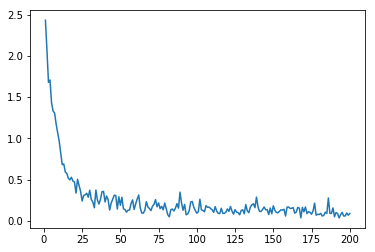

In [18]:
#plot loss
loss = history.history['loss']

epochs = range(1,len(loss)+1)

plt.plot(epochs,loss)


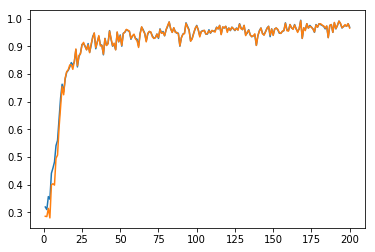

In [19]:
#plot accuracy and f1
acc = history.history['acc']
f1 = history.history['f1']

epochs = range(1,len(loss)+1)

plt.plot(epochs,acc)
plt.plot(epochs,f1)


In [20]:
from sklearn import metrics
#training and dev prediction
y_hat_train = model.predict(X_train)

target_names = ['Normal','AF','Other','Noise']
score = metrics.accuracy_score(y_train, y_hat_train)
print("accuracy:   %0.3f" % score)
#report de metricas
print("classification report:")
print(metrics.classification_report(y_train, y_hat_train,target_names=target_names))


print("confusion matrix:")
print(metrics.confusion_matrix(y_train, y_hat_train))

320/320 [==============================] - 3s 10ms/step
accuracy:   0.997
classification report:
             precision    recall  f1-score   support

     Normal       0.99      1.00      0.99        80
         AF       1.00      0.99      0.99        80
      Other       1.00      1.00      1.00        80
      Noise       1.00      1.00      1.00        80

avg / total       1.00      1.00      1.00       320

confusion matrix:
[[80  0  0  0]
 [ 1 79  0  0]
 [ 0  0 80  0]
 [ 0  0  0 80]]


In [21]:
from sklearn import metrics
#training and dev prediction
y_hat_dev = model.predict(X_dev)

target_names = ['Normal','AF','Other','Noise']



score = metrics.accuracy_score(y_dev, y_hat_dev)
print("accuracy:   %0.3f" % score)
#report de metricas
print("classification report:")
print(metrics.classification_report(y_dev, y_hat_dev,target_names=target_names))


print("confusion matrix:")
print(metrics.confusion_matrix(y_dev, y_hat_dev))

80/80 [==============================] - 1s 10ms/step
accuracy:   0.362
classification report:
             precision    recall  f1-score   support

     Normal       0.27      0.55      0.36        20
         AF       0.43      0.30      0.35        20
      Other       0.42      0.25      0.31        20
      Noise       0.54      0.35      0.42        20

avg / total       0.41      0.36      0.36        80

confusion matrix:
[[11  3  4  2]
 [11  6  1  2]
 [ 9  4  5  2]
 [10  1  2  7]]
